<a href="https://colab.research.google.com/github/codingpotato/pill-detection/blob/master/pill_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

## Environment Variables

In [1]:
%mkdir -p work
%cd work

/content/work


In [0]:
import os

WORK_DIR = %pwd
if isinstance(WORK_DIR, unicode):
    WORK_DIR = WORK_DIR.encode('Latin-1')
SOURCE_DIR = os.path.join(WORK_DIR, 'pill-detection')
IMAGE_DIR = os.path.join(SOURCE_DIR, 'images')
TEST_IMAGE_DIR = os.path.join(SOURCE_DIR, 'test_images')

TRAIN_IMAGE_DIR = os.path.join(WORK_DIR, 'train_images')
MODEL_DIR = os.path.join(WORK_DIR, 'train_data')
EXPORTED_DIR = os.path.join(WORK_DIR, 'exported')

MODELS_DIR = os.path.join(WORK_DIR, 'models')
RESEARCH_DIR = os.path.join(MODELS_DIR, 'research')
SLIM_DIR = os.path.join(RESEARCH_DIR, 'slim')
OBJECT_DETECTION_DIR = os.path.join(RESEARCH_DIR, 'object_detection')

In [0]:
%mkdir -p $TRAIN_IMAGE_DIR
%mkdir -p $MODEL_DIR
%mkdir -p $EXPORTED_DIR

## Clone Pill Detection

In [4]:
!git clone https://github.com/codingpotato/pill-detection.git

Cloning into 'pill-detection'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 158 (delta 85), reused 57 (delta 22), pack-reused 0
Receiving objects: 100% (158/158), 1.90 MiB | 14.13 MiB/s, done.
Resolving deltas: 100% (85/85), done.


## Install Tensorflow Object Detection API

In [5]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 22830, done.
remote: Total 22830 (delta 0), reused 0 (delta 0), pack-reused 22830
Receiving objects: 100% (22830/22830), 562.75 MiB | 30.02 MiB/s, done.
Resolving deltas: 100% (13317/13317), done.
Checking out files: 100% (2850/2850), done.


In [6]:
!pip install Cython
!apt-get install protobuf-compiler
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools $RESEARCH_DIR

    100% |████████████████████████████████| 2.0MB 8.0MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libprotobuf10 libprotoc10
The following NEW packages will be installed:
  libprotobuf10 libprotoc10 protobuf-compiler
0 upgraded, 3 newly installed, 0 to remove and 5 not upgraded.
Need to get 1,242 kB of archives.
After this operation, 4,942 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotobuf10 amd64 3.0.0-9.1ubuntu1 [651 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotoc10 amd64 3.0.0-9.1ubuntu1 [566 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 protobuf-compiler amd64 3.0.0-9.1ubuntu1 [24.5 kB]
Fetched 1,242 kB in 1s (938 kB/s)
Selecting previously unselected package libprotobuf10:amd64.
(Reading database ... 22298 files and directories currently installed.)
Preparing to unpack ..

In [7]:
%env PYTHONPATH=$RESEARCH_DIR:$SLIM_DIR

env: PYTHONPATH=/content/work/models/research:/content/work/models/research/slim


In [8]:
%cd $RESEARCH_DIR
!protoc object_detection/protos/*.proto --python_out=.

/content/work/models/research


## Test Tensorflow Object Detection API

In [9]:
!python $OBJECT_DETECTION_DIR/builders/model_builder_test.py

......................
----------------------------------------------------------------------
Ran 22 tests in 0.121s

OK


# Prepare Images

In [0]:
%matplotlib inline

## Generate Training Images

In [0]:
from PIL import Image
from random import randint, uniform

image_width = 1000
image_height = 1000
number_of_images = 100

def generate_images(name):
    image_path = os.path.join(IMAGE_DIR, name + '.png')
    pill_image = Image.open(image_path)
    
    for index in range(1, number_of_images + 1):
        image = Image.new('RGB', (image_width, image_height), '#000')
        
        width = int(pill_image.size[0] * uniform(0.9, 1.1))
        height = int(pill_image.size[1] * uniform(0.9, 1.1))
        scaled_image = pill_image.resize((width, height), Image.ANTIALIAS)
        
        rotated_image = scaled_image.rotate(randint(0, 360), expand=True)
        
        x = randint(0, image_width - rotated_image.size[0])
        y = randint(0, image_height - rotated_image.size[1])
        image.paste(rotated_image, (x, y), rotated_image)
        
        save_path = os.path.join(TRAIN_IMAGE_DIR, 
                                 name + '_' + str(index) + '.jpg')
        image.save(save_path)

In [0]:
files = os.listdir(IMAGE_DIR)
labels = sorted([os.path.splitext(f)[0] for f in files])

In [0]:
for label in labels:
    generate_images(label)

## Detect Bounding Rectangle

In [0]:
import cv2

def boundingRect(image):
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image_bw = cv2.threshold(image_bw, 10, 255, cv2.THRESH_BINARY)
    _, contours, _ = cv2.findContours(image_bw,
                                    cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    max_area = 0
    x, y, w, h = 0, 0, 0, 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)

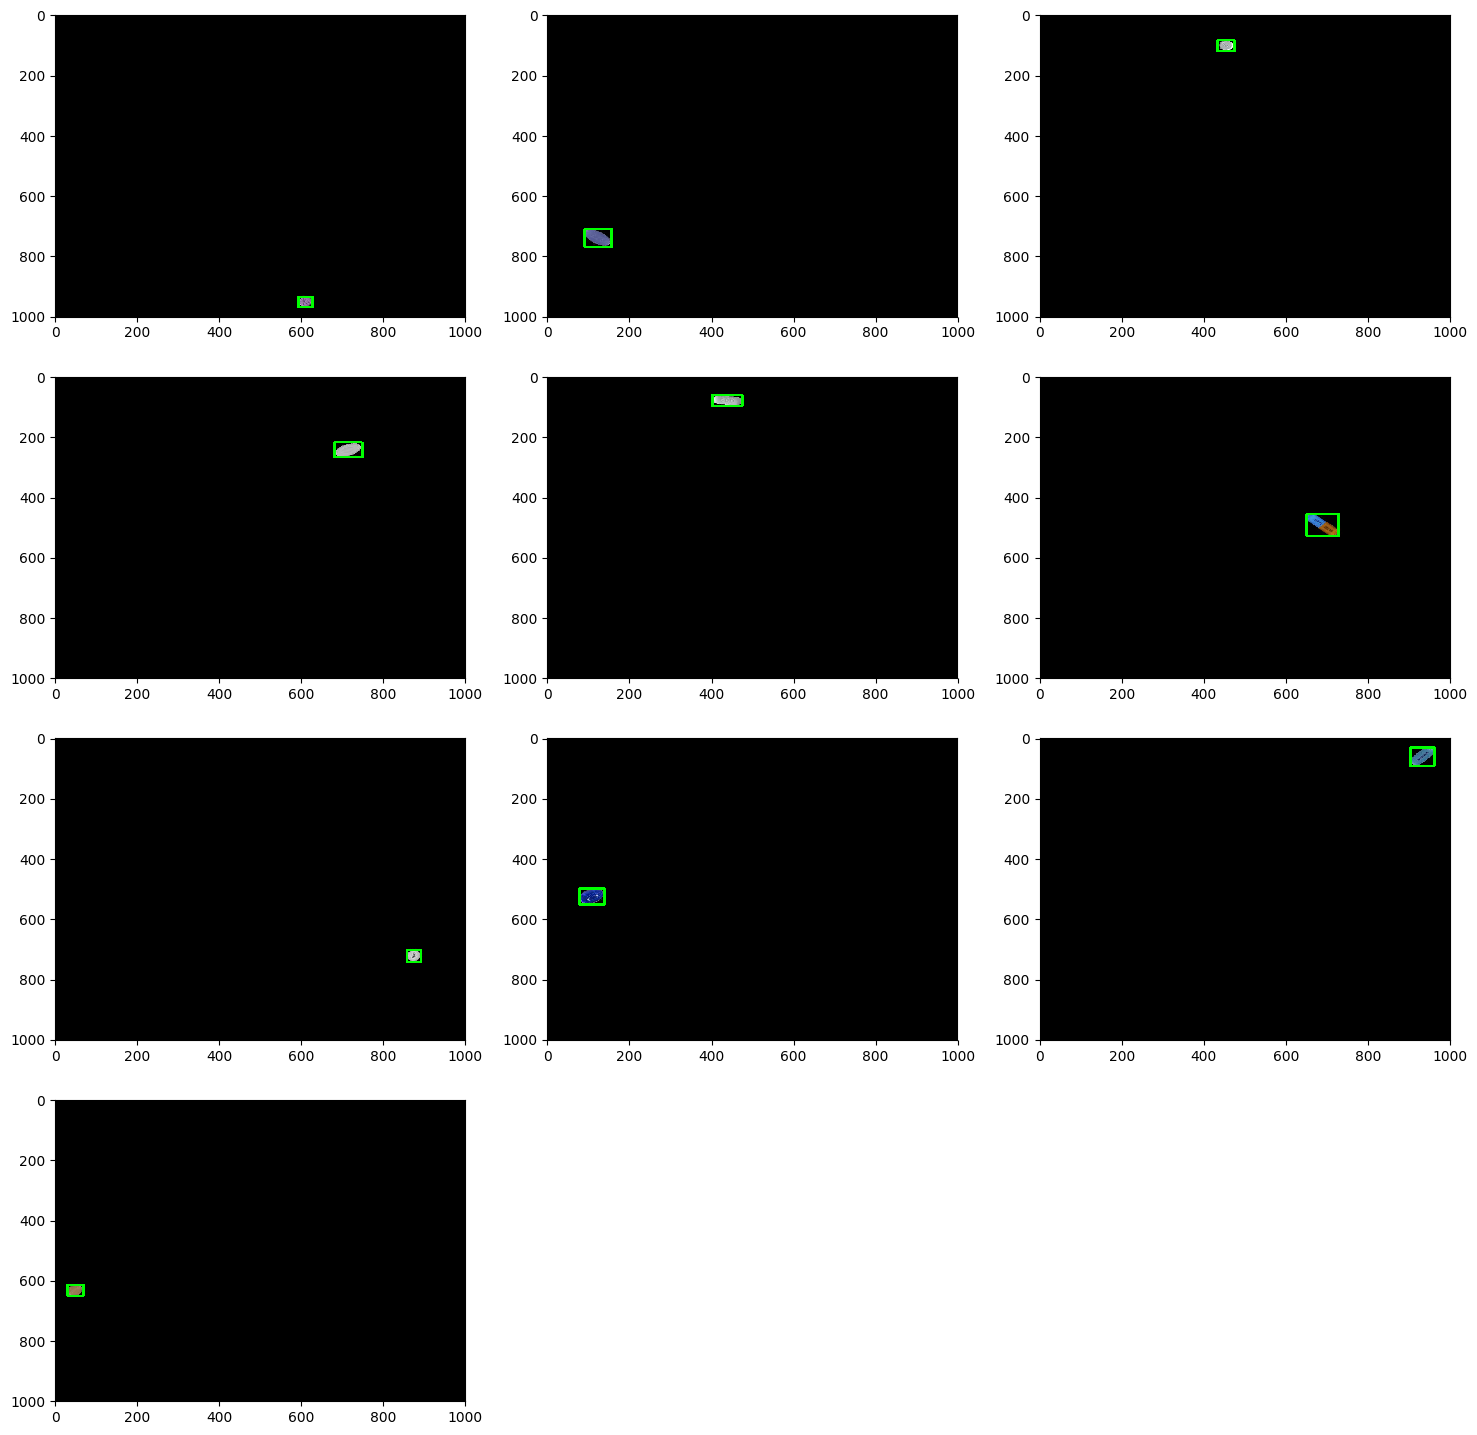

In [17]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(18, 18))
index = 1
for label in labels:
    plt.subplot(4, 3, index)
    image_path = os.path.join(TRAIN_IMAGE_DIR, label + '_1.jpg')
    image = cv2.imread(image_path)
    x, y, w, h = boundingRect(image)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 5)
    plt.imshow(image, aspect='auto')
    index += 1
plt.show()

# Prepare Data

## Create Label Map

In [0]:
file_path = os.path.join(MODEL_DIR, 'label_map.pbtxt')
with open(file_path, 'w') as f:
    index = 1
    for label in labels:
        text = "item {\n  id: " + str(index) + "\n  name: '" + label + "'\n}\n\n"
        f.write(text)
        index += 1

## Generate TF Record

In [0]:
import tensorflow as tf
from object_detection.utils import dataset_util


def generate_tf_record(record_path, start, size):
    writer = tf.python_io.TFRecordWriter(record_path)
    label_index = 1
    for label in labels:
        for index in range(start, start + size):
            filename = os.path.join(TRAIN_IMAGE_DIR,
                                    label + '_' + str(index) + '.jpg')
            image = cv2.imread(filename)
            x, y, w, h = boundingRect(image)
    
            image_format = b'jpg'
            with tf.gfile.GFile(filename, 'rb') as fid:
                encoded_png = fid.read()
      
            xmin = float(x) / image_width
            ymin = float(y) / image_height
            xmax = float(x + w - 1) / image_width
            ymax = float(y + h - 1) / image_height
      
            tf_example = tf.train.Example(features=tf.train.Features(feature={
                'image/height': dataset_util.int64_feature(image_width),
                'image/width': dataset_util.int64_feature(image_height),
                'image/filename': dataset_util.bytes_feature(filename),
                'image/source_id': dataset_util.bytes_feature(filename),
                'image/encoded': dataset_util.bytes_feature(encoded_png),
                'image/format': dataset_util.bytes_feature(image_format),
                'image/object/bbox/xmin': dataset_util.float_list_feature(
                    [xmin]),
                'image/object/bbox/xmax': dataset_util.float_list_feature(
                    [xmax]),
                'image/object/bbox/ymin': dataset_util.float_list_feature(
                    [ymin]),
                'image/object/bbox/ymax': dataset_util.float_list_feature(
                    [ymax]),
                'image/object/class/text': dataset_util.bytes_list_feature(
                    [label]),
                'image/object/class/label': dataset_util.int64_list_feature(
                    [label_index])
            }))
            writer.write(tf_example.SerializeToString())
        label_index += 1
    writer.close()

In [0]:
train_record = os.path.join(MODEL_DIR, 'train.record')
generate_tf_record(train_record, 1, 80)
test_record = os.path.join(MODEL_DIR, 'test.record')
generate_tf_record(test_record, 81, 20)

## Download Pre-Trained Model

Select one of the pre-trained model

In [0]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz

--2018-11-25 10:32:24--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.197.128, 2607:f8b0:400e:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593445323 (566M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet101_coco_2018_01_28.tar.gz’

faster_rcnn_resnet1 100%[===================>] 565.95M   190MB/s    in 3.0s    

2018-11-25 10:32:27 (190 MB/s) - ‘faster_rcnn_resnet101_coco_2018_01_28.tar.gz’ saved [593445323/593445323]



In [0]:
!tar xfv faster_rcnn_resnet101_coco_2018_01_28.tar.gz
!cp faster_rcnn_resnet101_coco_2018_01_28/model.ckpt* $MODEL_DIR

faster_rcnn_resnet101_coco_2018_01_28/
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet101_coco_2018_01_28/checkpoint
faster_rcnn_resnet101_coco_2018_01_28/pipeline.config
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.meta
faster_rcnn_resnet101_coco_2018_01_28/saved_model/
faster_rcnn_resnet101_coco_2018_01_28/saved_model/saved_model.pb
faster_rcnn_resnet101_coco_2018_01_28/saved_model/variables/
faster_rcnn_resnet101_coco_2018_01_28/frozen_inference_graph.pb


In [21]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz

--2018-11-26 01:23:51--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.98.128, 2607:f8b0:400e:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.98.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

faster_rcnn_resnet5 100%[===================>] 363.69M   196MB/s    in 1.9s    

2018-11-26 01:23:54 (196 MB/s) - ‘faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]



In [22]:
!tar xfv faster_rcnn_resnet50_coco_2018_01_28.tar.gz
!cp faster_rcnn_resnet50_coco_2018_01_28/model.ckpt* $MODEL_DIR

faster_rcnn_resnet50_coco_2018_01_28/
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet50_coco_2018_01_28/checkpoint
faster_rcnn_resnet50_coco_2018_01_28/pipeline.config
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.meta
faster_rcnn_resnet50_coco_2018_01_28/saved_model/
faster_rcnn_resnet50_coco_2018_01_28/saved_model/saved_model.pb
faster_rcnn_resnet50_coco_2018_01_28/saved_model/variables/
faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb


## Create Config file

In [0]:
SAMPLE_CONFIG_FILE = 'faster_rcnn_resnet50_pets.config'
CONFIG_FILE = 'faster_rcnn_resnet50.config'

In [0]:
!cp $OBJECT_DETECTION_DIR/samples/configs/$SAMPLE_CONFIG_FILE $MODEL_DIR/$CONFIG_FILE
!sed -i "s|num_classes: 37|num_classes: 10|g" $MODEL_DIR/$CONFIG_FILE
!sed -i "s|PATH_TO_BE_CONFIGURED|$MODEL_DIR|g" $MODEL_DIR/$CONFIG_FILE
!sed -i "s|pet_label_map.pbtxt|label_map.pbtxt|g" $MODEL_DIR/$CONFIG_FILE
!sed -i "s|pet_faces_train.record-?????-of-00010|train.record|g" $MODEL_DIR/$CONFIG_FILE
!sed -i "s|pet_faces_val.record-?????-of-00010|test.record|g" $MODEL_DIR/$CONFIG_FILE

# Train

In [0]:
get_ipython().system_raw('python object_detection/model_main.py \
    --pipeline_config_path=$MODEL_DIR/$CONFIG_FILE \
    --model_dir=$MODEL_DIR \
    --num_train_steps=50000 \
    --sample_1_of_n_eval_examples=1 \
    --alsologtostderr 2> $MODEL_DIR/train.log &')

# Download Model

In [0]:
!mkdir $EXPORTED_DIR
!python object_detection/export_inference_graph.py \
  --input_type image_tensor \
  --pipeline_config_path $MODEL_DIR/$CONFIG_FILE \
  --trained_checkpoint_prefix $MODEL_DIR/model.ckpt-18808 \
  --output_directory $EXPORTED_DIR

rm: cannot remove '/content/exported_graphs': No such file or directory
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
W1118 14:06:17.966794 139890043742080 tf_logging.py:125] From /content/models/research/object_detection/exporter.py:328: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
W1118 14:06:17.973248 139890043742080 tf_logging.py:125] From /content/models/research/object_detection/exporter.py:482: print_model_analysis (from tensorflow.contrib.tfprof.model_analyzer) is deprecated and will be removed after 2018-01-01.
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. 

In [0]:
!zip -r exp_g.zip $EXPORTED_DIR

  adding: content/exported_graphs/ (stored 0%)
  adding: content/exported_graphs/checkpoint (deflated 42%)
  adding: content/exported_graphs/saved_model/ (stored 0%)
  adding: content/exported_graphs/saved_model/saved_model.pb (deflated 16%)
  adding: content/exported_graphs/saved_model/variables/ (stored 0%)
  adding: content/exported_graphs/model.ckpt.data-00000-of-00001 (deflated 8%)
  adding: content/exported_graphs/model.ckpt.meta (deflated 95%)
  adding: content/exported_graphs/model.ckpt.index (deflated 69%)
  adding: content/exported_graphs/frozen_inference_graph.pb (deflated 15%)
  adding: content/exported_graphs/pipeline.config (deflated 69%)


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
uploaded = drive.CreateFile({'title': 'exp_g.zip'})
uploaded.SetContentFile('exp_g.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1UyhAr_WPwJdhWB8TzeULJCY36TVwOmmi


# TensorBoard

In [34]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2018-11-26 01:45:51--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.203.53.176, 52.22.236.254, 52.207.111.186, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.203.53.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.52MB/s    in 0.5s    

2018-11-26 01:45:52 (9.52 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
get_ipython().system_raw('tensorboard --logdir $WORK_DIR --host 0.0.0.0 --port 6006 &')

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [37]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
 "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://6c8361b1.ngrok.io


# Status

In [57]:
!uptime

 05:03:25 up  4:00,  0 users,  load average: 0.85, 0.78, 0.75


In [58]:
!ps -ef

UID          PID    PPID  C STIME TTY          TIME CMD
root           1       0  0 01:03 ?        00:00:00 /bin/bash -e /datalab/run.sh
root           9       1  0 01:03 ?        00:00:01 node /tools/node/bin/forever
root          30       9  0 01:03 ?        00:00:05 /tools/node/bin/node /datala
root          54      30  0 01:03 ?        00:00:09 /usr/bin/python2 /usr/local/
root          61      54  0 01:04 ?        00:00:52 /usr/bin/python -m ipykernel
root         353       1 55 01:37 ?        01:54:28 python2 object_detection/mod
root        3064       1  4 01:45 ?        00:07:55 /usr/bin/python2 /usr/local/
root        3072       1  0 01:46 ?        00:01:06 ./ngrok http 6006
root        6221      61 99 05:03 ?        00:00:01 ps -ef


In [29]:
!pwd

/content/work/models/research


In [61]:
!ls $MODEL_DIR

checkpoint
eval_0
events.out.tfevents.1543196241.8d40761378b1
faster_rcnn_resnet50.config
graph.pbtxt
label_map.pbtxt
model.ckpt-27479.data-00000-of-00001
model.ckpt-27479.index
model.ckpt-27479.meta
model.ckpt-28787.data-00000-of-00001
model.ckpt-28787.index
model.ckpt-28787.meta
model.ckpt-30095.data-00000-of-00001
model.ckpt-30095.index
model.ckpt-30095.meta
model.ckpt-31620.data-00000-of-00001
model.ckpt-31620.index
model.ckpt-31620.meta
model.ckpt-32930.data-00000-of-00001
model.ckpt-32930.index
model.ckpt-32930.meta
model.ckpt.data-00000-of-00001
model.ckpt.index
model.ckpt.meta
test.record
train.log
train.record


In [31]:
%cat $MODEL_DIR/train.log

/content/work/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "object_detection/model_main.py", line 26, in <module>
    from object_detection import model_lib
  File "/content/work/models/research/object_detection/model_lib.py", line 27, in <module>
    from object_detection import eval_util
  File "/content/work/models/research/object_detection/eval_util.py", line 27, in <module>
    from object_detection.metrics import coco_evaluation
  File "/content/work/models/research/object_detection/metrics/coco_evaluation.py", line 20, in <module>
    from object_detection.metrics import coco_tools
  File "/content/work/models/research/object_dete

# Test Model

## Export Graphs

In [62]:
!rm -rf $EXPORTED_DIR
!mkdir -p $EXPORTED_DIR
!python object_detection/export_inference_graph.py \
  --input_type image_tensor \
  --pipeline_config_path $MODEL_DIR/$CONFIG_FILE \
  --trained_checkpoint_prefix $MODEL_DIR/model.ckpt-32930 \
  --output_directory $EXPORTED_DIR

Instructions for updating:
keep_dims is deprecated, use keepdims instead
W1126 05:40:24.829924 140022261094272 tf_logging.py:125] From /content/work/models/research/object_detection/predictors/heads/box_head.py:93: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
W1126 05:40:26.809070 140022261094272 tf_logging.py:125] From /content/work/models/research/object_detection/exporter.py:328: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.m

## Load Model into Memory

In [63]:
import numpy as np
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages

In [0]:
frozen_graph_path = os.path.join(EXPORTED_DIR, 'frozen_inference_graph.pb')
label_map_path = os.path.join(MODEL_DIR, 'label_map.pbtxt')

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(frozen_graph_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Load Label Map

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(
    label_map_path, use_display_name=True)

## Detection

In [0]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    data = np.array(image.getdata()).reshape(
        (im_height, im_width, 3))
    return data.astype(np.uint8)

In [0]:
test_images = os.listdir(TEST_IMAGE_DIR)

In [0]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name 
                                for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates
                # to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], 
                                             tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0],
                                           [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0],
                                           [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(
                tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

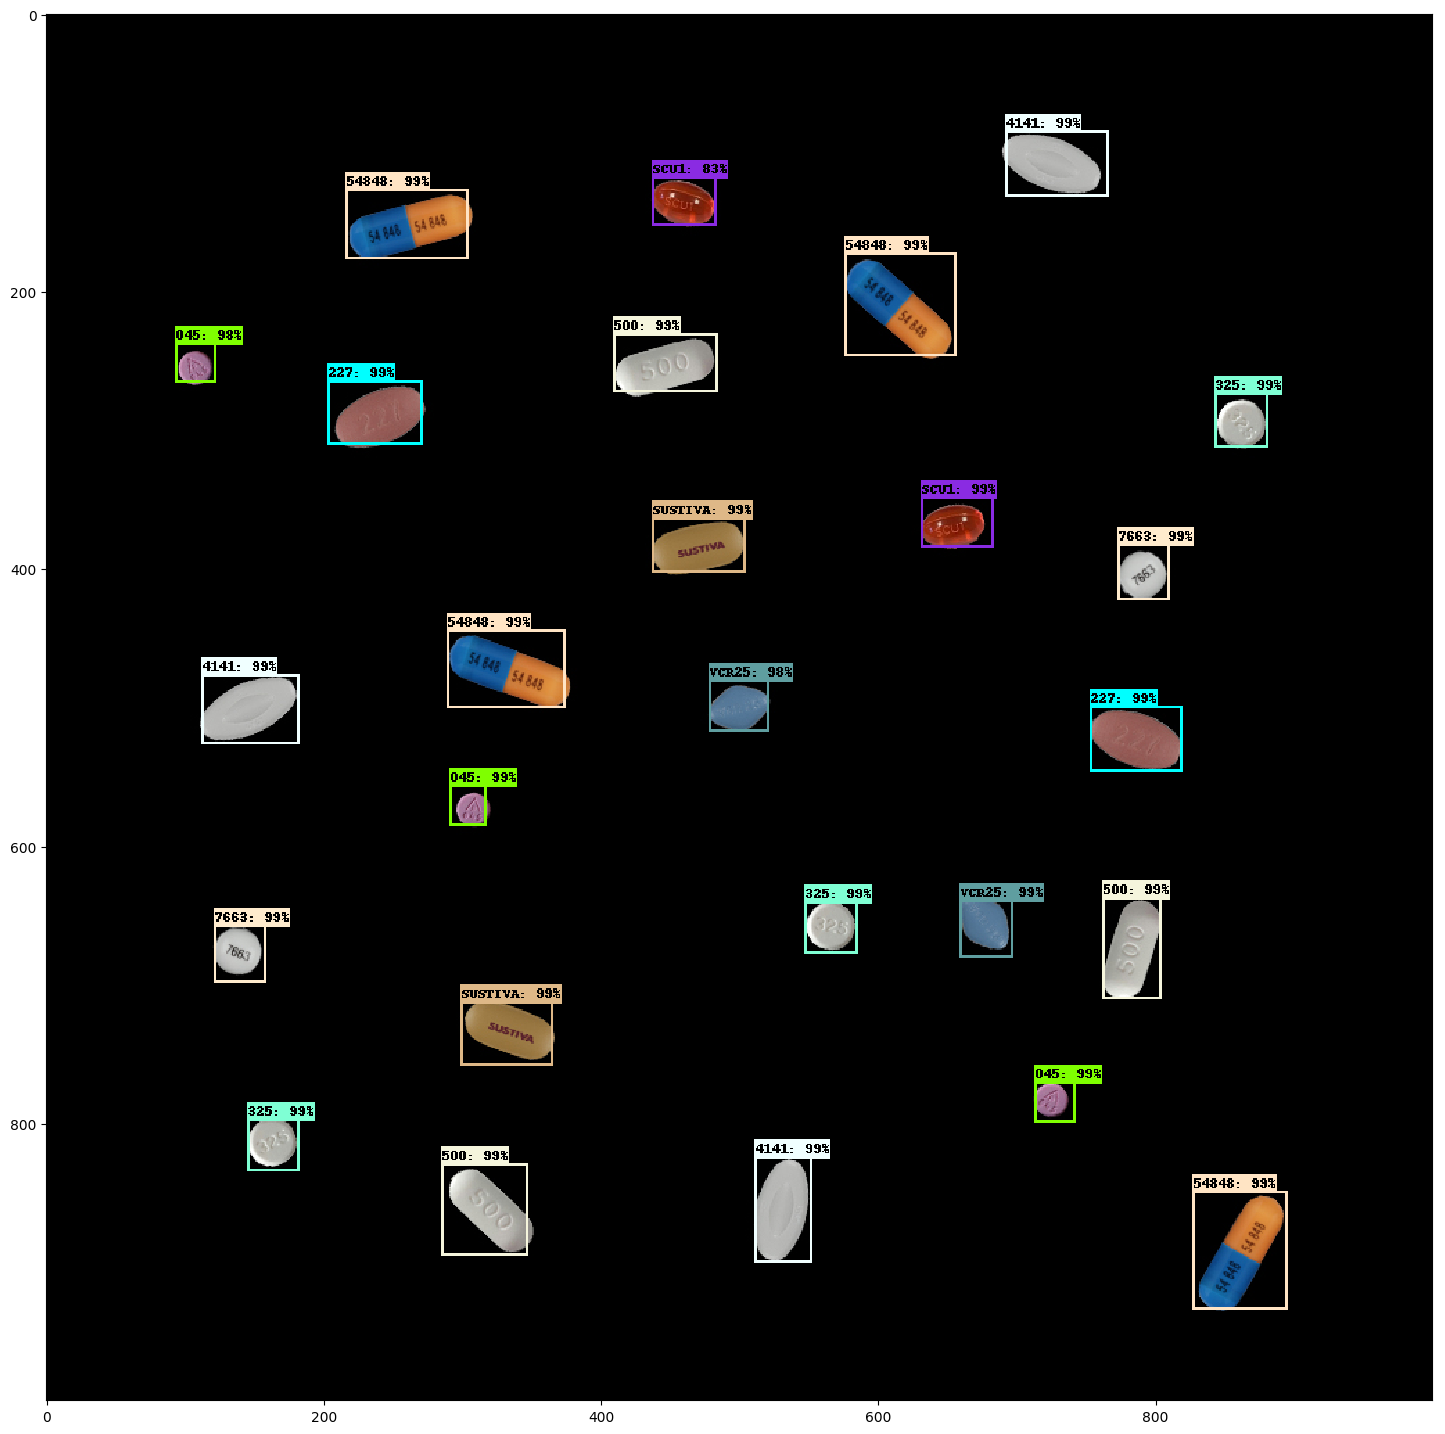

In [70]:
for filename in test_images:
    image = Image.open(os.path.join(TEST_IMAGE_DIR, filename))
    # the array based representation of the image will be used later
    # in order to prepare the result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=2,
        max_boxes_to_draw=50)
    plt.figure(figsize=(18, 18))
    plt.imshow(image_np)